In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import math as mth
import time
%matplotlib inline

In [10]:
def presPoisson_7(p, dx, dy,rho,nu,u,v):
    pn = np.empty_like(p)
    pn = p.copy()
     
    #Term in square brackets
    b[1:-1,1:-1]=rho*(1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx)+(v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))-\
                 ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx))**2-\
                 2*((u[2:,1:-1]-u[0:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,0:-2])/(2*dx))-\
                 ((v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))**2)

    for q in range(nit):
        pn = p.copy()
        p[1:-1,1:-1] = ((pn[1:-1,2:]+pn[1:-1,0:-2])*dy**2+(pn[2:,1:-1]+pn[0:-2,1:-1])*dx**2)/\
                        (2*(dx**2+dy**2)) -\
                        dx**2*dy**2/(2*(dx**2+dy**2))*b[1:-1,1:-1]
        
        ##at y = 2
        p[-1,:] = p[-2,:] - rho*nu/dy*(-2*v[-2,:]+v[-3,:])
        
        #at y = 0
        p[0,:] = p[1,:] - rho*nu/dy*(-2*v[1,:]+v[2,:])
        
        #at x = 0
        p[:,0] = p[:,1] - rho*nu/dx*(-2*u[:,1]+u[:,2])
        
        #at x = 2
        p[:,-1] = p[:,-2] - rho*nu/dx*(-2*u[:,-2]+u[:,-3])      
        
    return p

def presPoisson_10(p, dx, dy,rho, botb, dpth, lftb, wdth, ny, nx):
    pn = np.empty_like(p)
    p = np.zeros((ny, nx))
    
  
    # Term in square brackets
    b[1:-1,1:-1]=rho*(1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx)+(v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))-\
                 ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx))**2-\
                 2*((u[2:,1:-1]-u[0:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,0:-2])/(2*dx))-\
                 ((v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))**2)

    for q in range(nit):
        pn = p.copy()
        p[1:-1,1:-1] = ((pn[1:-1,2:]+pn[1:-1,0:-2])*dy**2+(pn[2:,1:-1]+pn[0:-2,1:-1])*dx**2)/\
                        (2*(dx**2+dy**2)) -\
                        dx**2*dy**2/(2*(dx**2+dy**2))*b[1:-1,1:-1]

       
        # Apply the Neumann boundary condition as recommended above on all sides 
        p[-1,:] = p[-2,:] - rho*nu/dy*(-2*v[-2,:]+v[-3,:]) ## at y = 2
        p[0,:] = p[1,:] - rho*nu/dy*(-2*v[1,:]+v[2,:])     ## at y = 0
        
       
        p[:,0] = p[:,1] - rho*nu/dx*(-2*u[:,1]+u[:,2])     ## at x = 0
        p[:,-1] = p[:,-2] - rho*nu/dx*(-2*u[:,-2]+u[:,-3]) ## at x = 2   
        
        # We apply the same concept for boundary conditions at the top and bottom surfaces of the obstacles.
        # At bottom surface:      
        p[botb,lftb:(lftb+wdth+1)] = p[botb-1,lftb:(lftb+wdth+1)] - rho*nu/dy*(-2*v[botb-1,lftb:(lftb+wdth+1)]+v[botb-2,lftb:(lftb+wdth+1)])
        
        # At top surface:
        p[(botb+dpth),lftb:(lftb+wdth+1)] = p[(botb+dpth+1),lftb:(lftb+wdth+1)] - rho*nu/dy*(-2*v[(botb+dpth+1),lftb:(lftb+wdth+1)]+v[(botb+dpth+2),lftb:(lftb+wdth+1)]) #at y = 0
           
        # Likewise for the right and left surfaces of the obstacles
        # At the left surface:
        p[botb:(botb+dpth+1),lftb] = p[botb:(botb+dpth+1),lftb-1] - rho*nu/dx*(-2*u[botb:(botb+dpth+1),lftb-1]+u[botb:(botb+dpth+1),lftb-2]) #at x = 2
        
        # At the right surface:
        p[botb:(botb+dpth+1),(lftb+wdth)] = p[botb:(botb+dpth+1),(lftb+wdth+1)] - rho*nu/dx*(-2*u[botb:(botb+dpth+1),(lftb+wdth+1)]+u[botb:(botb+dpth+1),(lftb+wdth+2)]) #at x = 0
        
        # Pressure values inside obstacle should be zero
        # since there is no pressure flux in and out of the obstacle
        p[(botb+1):(botb+dpth),(lftb+1):(lftb+wdth)] = 0
        
    
    return p

In [11]:
def cavityFlow_9(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        p = presPoisson_7(p, dx, dy, rho, nu, u, v)
        
        u[1:-1,1:-1] = un[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[0:-2,1:-1])-\
                        dt/(2*rho*dx)*(p[1:-1,2:]-p[1:-1,0:-2])+\
                        nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])+\
                        dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1]))

        v[1:-1,1:-1] = vn[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[0:-2,1:-1])-\
                        dt/(2*rho*dy)*(p[2:,1:-1]-p[0:-2,1:-1])+\
                        nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])+\
                        (dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])))

        u[0,:] = 0
        u[:,0] = 0
        u[:,-1] = 0
        u[-1,:] = Uwall    #set velocity on cavity lid equal to Uwall
        v[0,:] = 0
        v[-1,:]=0
        v[:,0] = 0
        v[:,-1] = 0
        
        
    return u, v, p


def cavityFlow_16(nt, u, v, dt, dx, dy, p, rho, nu, botb, dpth, lftb, wdth, X, Y, u_start):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    #--------------------------------------------
    # Initialise u values as initial condition
    #--------------------------------------------
    u[:,0] = u_start

    #-------------------------------------
    # Start iteration through timesteps
    #-------------------------------------
    for n in range(nt):
      
        un = u.copy()
        vn = v.copy()
        
        p = presPoisson_10(p, dx, dy, rho, botb, dpth, lftb, wdth, ny, nx) 
        
        #===================================
        # to locate position of maximum pressure and the maximum value itself, and the corresponding U and V
        # for debugging purposes
        #print(np.where(p == p.max()))
        #print(p.max())
        #print ("--- time: " + str(n))
        #print("P:" + str(p[40,68]))
        #print("U:" + str(u[40,68]))
        #print("V:" + str(v[40,68]))
        #===================================
        
        u[1:-1,1:-1] = un[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[0:-2,1:-1])-\
                        dt/(2*rho*dx)*(p[1:-1,2:]-p[1:-1,0:-2])+\
                        nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])+\
                        dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1]))

        v[1:-1,1:-1] = vn[1:-1,1:-1]-\
                        un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,0:-2])-\
                        vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[0:-2,1:-1])-\
                        dt/(2*rho*dy)*(p[2:,1:-1]-p[0:-2,1:-1])+\
                        nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])+\
                        (dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])))

        #-------------------------------------------------------------
        # Apply boundary conditions to the inlet, exit points, as well
        # as the top and bottom boundary conditions.
        #-------------------------------------------------------------
        # Prescribing inlet boundary condition at the inlet itself.
        # i.e. at every time step, a constant u-direction speed enters the pipe
        # Ref: Eq. 2.53 "Essential Computational Fluid Dynamics", Zikanov (2010)
        u[:,0] = u_start

        # Near the exit, only an artificial boundary condition can be set since the
        # flow is artificially cut off, and therefore not possible to predict
        # what will occur at the exit, and how it can conversely affect flow
        # within the domain. Set zero gradient at the exit in the direction of x for each
        # time step
        # Ref: Eq. 2.54 "Essential Computational Fluid Dynamics", Zikanov (2010)
        u[:,-1] = u[:,-2]
        
        # Bottom and top surface of pipe has zero tangential velocity - no slip boundary condition
        u[0,:] = 0
        u[-1,:] = 0
        
        # Also set the vertical velocity at the inlet and exit to be zero, i.e. force laminar flow
        v[:,-1] = 0  # at exit
        v[:,0]  = 0  # at inlet
        
        # likewise vertical velocity at each of the bottom and top surface is also zero
        v[0,:]  = 0 # bottom surface
        v[-1,:] = 0 # top surface
        
        #-------------------------------------------------------------
        # Apply boundary conditions to the obstacle
        #-------------------------------------------------------------  
        # zero velocity everywhere at the obstacle
        u[botb:(botb+dpth+1),lftb:(lftb+wdth+1)] = 0
        v[botb:(botb+dpth+1),lftb:(lftb+wdth+1)] = 0
        
        # save each plot at selected time step intervals (for debugging purposes)
        output_step = 10
        if (True):
            if (n % output_step) == 0:
                fig = plt.figure(figsize=(100,50), dpi=25)
                plt.contourf(X,Y,p,alpha=0.5)    ### plotting the pressure field as a contour
                plt.tick_params(axis='both', which='major', labelsize=40)
                cbar = plt.colorbar()
                cbar.ax.tick_params(labelsize=50) 
                #plt.contour(X, Y, p, cmap='cool', vmin=0, vmax=400)               ### plotting the pressure field outlines
                plt.contour(X, Y, u/v)
                plt.quiver(X[::qres,::qres],Y[::qres,::qres],u[::qres,::qres],v[::qres,::qres]) ##plotting velocity
                #plt.streamplot(X[::qres,::qres],Y[::qres,::qres],u[::qres,::qres],v[::qres,::qres],linewidth=2, cmap=plt.cm.autumn)
                
                # To overlay an artificial obstacle over the plot using plt.broken_barh
                plt.broken_barh([(x[lftb+1],x[lftb+wdth-2]-x[lftb+1])], (y[botb+1],y[botb+dpth-2]-y[botb+1]), facecolors='grey', alpha=0.8)
                plt.xlabel('X')
                plt.ylabel('Y')
                plt.title('time_step = ' + str(n) + ' nu = ' + str(nu), fontsize=40)
                # plot only every 10 plots
                if (n/output_step) < 10:
                    str_prepend = "0"
                else:
                    str_prepend = ""
                plt.close()
                
        
    return u, v, p

In [12]:
err_val=0.0001 #maximum relative error
maxiter=500 #maximum number of iteration 

#helper function to return the relative error
def relerror(old,new):
    i=np.where(abs(new) > 0)
    err=np.mean(((new[i]-old[i])/new[i])**2.)
    return err

#helper function to plot a 3d graph
def myplot3d(X,Y,data):
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.gca(projection='3d')                      
    surf = ax.plot_wireframe(X,Y,data[:])
    
def solvePoisson_Jacobi(p,f,deltax):
    iter=0
    
    while True:
        pn=p.copy()
        iter=iter+1
        p[:]=0
        #boundary conditions
        pn[0,:] = 0
        pn[-1,:] = 0
        pn[:,0] = 0
        pn[:,-1] = 0
        #finite difference scheme
        p[1:-1,1:-1]=0.25*(deltax*deltax*f[1:-1,1:-1]+(pn[1:-1,2:]+pn[1:-1,0:-2]+pn[2:,1:-1]+pn[0:-2,1:-1]))
        #stop if relative error is below bound
        if relerror(pn,p)<err_val:
            break
        if iter>maxiter:
            break
    #print iter
    #print relerror(pn,p)
    return p

def solvePoisson_GaussSeidel(p,f,deltax):
    iter=0
    while True:
        pn=p.copy()
        p[:]=0.
        iter=iter+1
        
        #boundary conditions
        pn[0,:] = 0
        pn[-1,:] = 0
        pn[:,0] = 0
        pn[:,-1] = 0
        #finite difference scheme
        for i in range(1,p.shape[0]-1): 
            for j in range (1,p.shape[1]-1):
                p[i,j]=0.25*(deltax*deltax*f[i,j]+pn[i,j+1]+p[i,j-1]+pn[i+1,j]+p[i-1,j])
        #stop if relative error is below bound
        if relerror(pn,p)<err_val:
            break
        if iter>maxiter:
            break
    #print iter
    #print relerror(pn,p)
    return p

#@autojit
def solvePoisson_SOR(p,f,deltax):
    iter=0
    beta=1.12
    while True:
        pn=p.copy()
        iter=iter+1
        
        #boundary conditions
        pn[0,:] = 0
        pn[-1,:] = 0
        pn[:,0] = 0
        pn[:,-1] = 0
        #finite difference scheme
        for i in range(1,p.shape[0]-1): 
            for j in range (1,p.shape[1]-1):
                p[i,j]=(1-beta)*pn[i,j]+0.25*beta*(deltax*deltax*f[i,j]+pn[i,j+1]+p[i,j-1]+pn[i+1,j]+p[i-1,j])

                #stop if relative error is below bound
        if relerror(pn,p)<err_val:
            break
        if iter>maxiter:
            break
    #print iterf
    #print relerror(pn,p)
    return p

/home/jhindenach40/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in true_divide
/home/jhindenach40/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


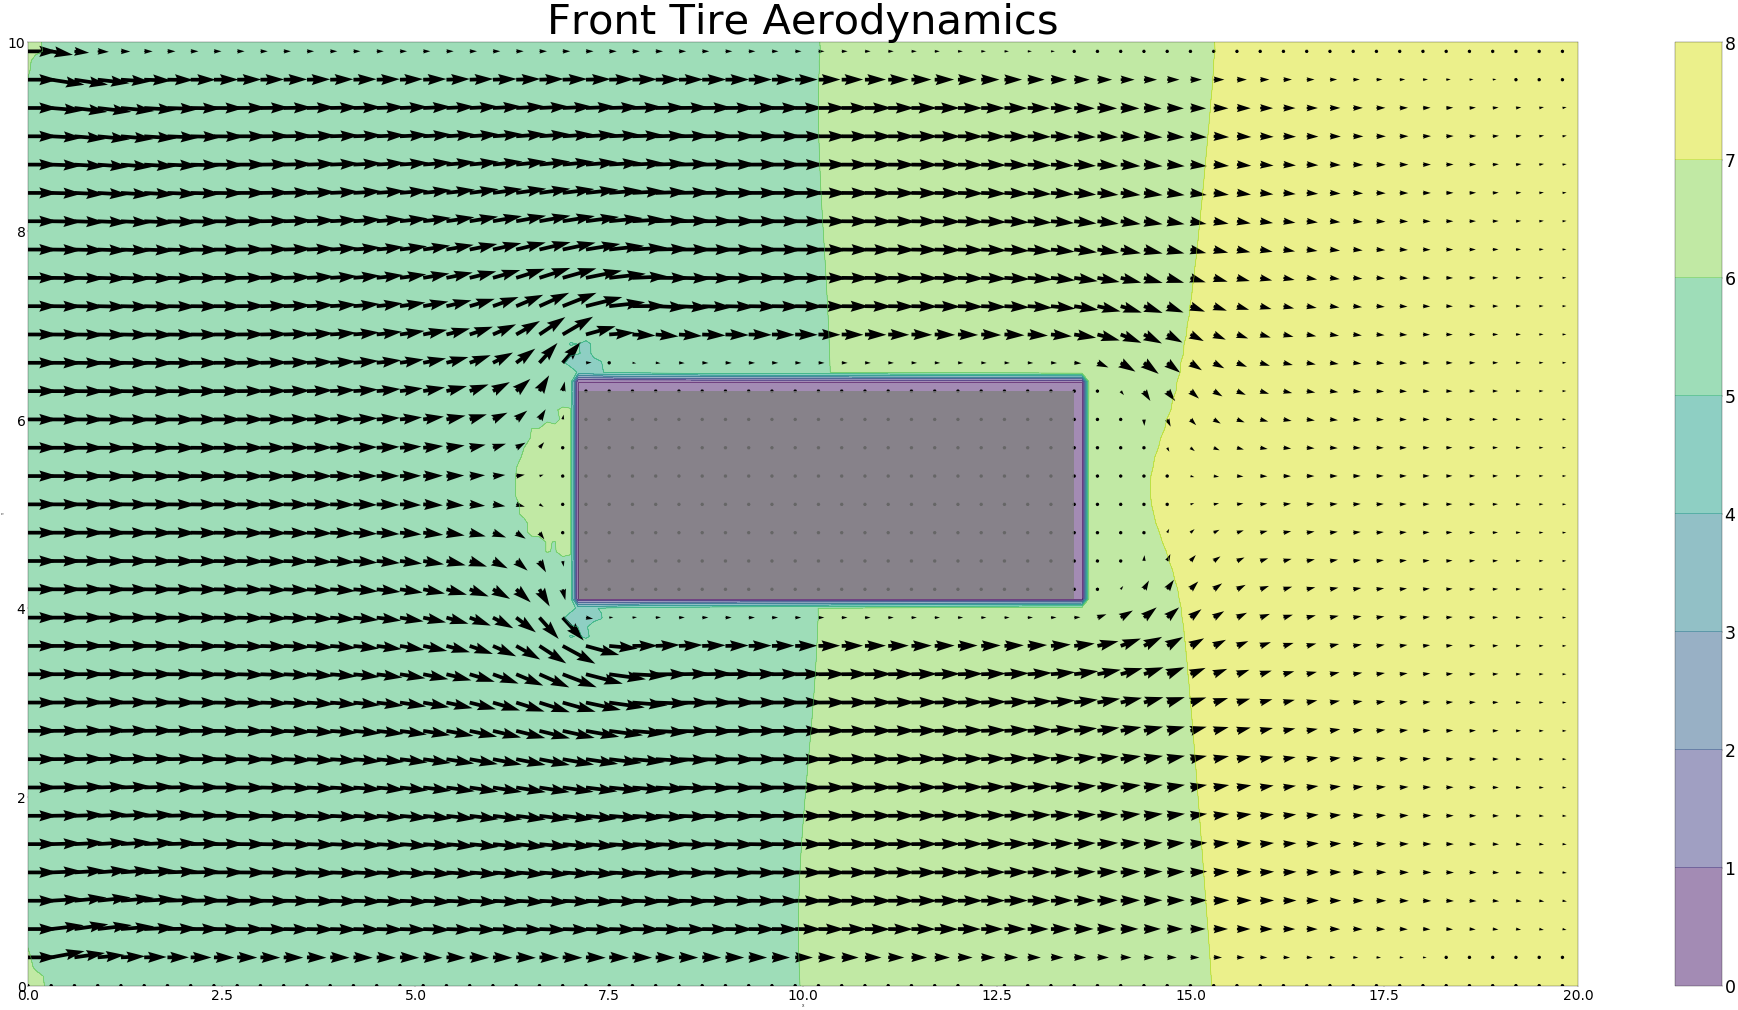

In [13]:
nx = 201  # x-points
ny = 101  # y-points
nit= 50
c =  1                       # phase propagation speed
x_span = 20.0
y_span = 10.0
dx = x_span/(nx-1)           # size of x-grid
dy = y_span/(ny-1)           # size of y-grid
x = np.linspace(0,x_span,nx) # last point included, so exactly nx points
y = np.linspace(0,y_span,ny) # last point included, so exactly ny points
X,Y = np.meshgrid(x,y)       # makes 2-dimensional mesh grid

botb  = 40           # bottom boundary of obstacle
dpth  = 25          # obstacle depth

lftb   = 70          # left boundary of obstacle
wdth   = 67          # obstacle width

Re = 50              # range from 10s to 100s 
nt = 1000            # timesteps

u_start = 1          # initial velocity at the start 
rho = 1              # density                
nu = ((dy*dpth)*u_start)/Re  # viscosity (UL/Re, Re = UL/nu, original value: 0.1)
dt = 0.001               # timesteps

qres = 3                 # quiver plot resolution

v = np.zeros((ny, nx))
u = np.ones((ny, nx))    # for u-velocity I initialise to 1 everywhere

p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

u, v, p = cavityFlow_16(nt, u, v, dt, dx, dy, p, rho, nu, botb, dpth, lftb, wdth, X, Y, u_start)

# Plot the last figure on screen
fig = plt.figure(figsize=(100,50), dpi=25)
plt.contourf(X, Y, p, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=50) 
plt.contour(X, Y, p)
plt.quiver(X[::qres,::qres],Y[::qres,::qres],u[::qres,::qres],v[::qres,::qres]) ##plotting velocity
plt.broken_barh([(x[lftb+1],x[lftb+wdth-2]-x[lftb+1])], (y[botb+1],y[botb+dpth-2]-y[botb+1]), facecolors='grey', alpha=0.8)
plt.xlabel('X')
plt.ylabel('Y');
plt.title('Front Tire Aerodynamics', fontsize = 120)
plt.savefig('FT_aero.jpeg')

/home/jhindenach40/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in true_divide
/home/jhindenach40/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


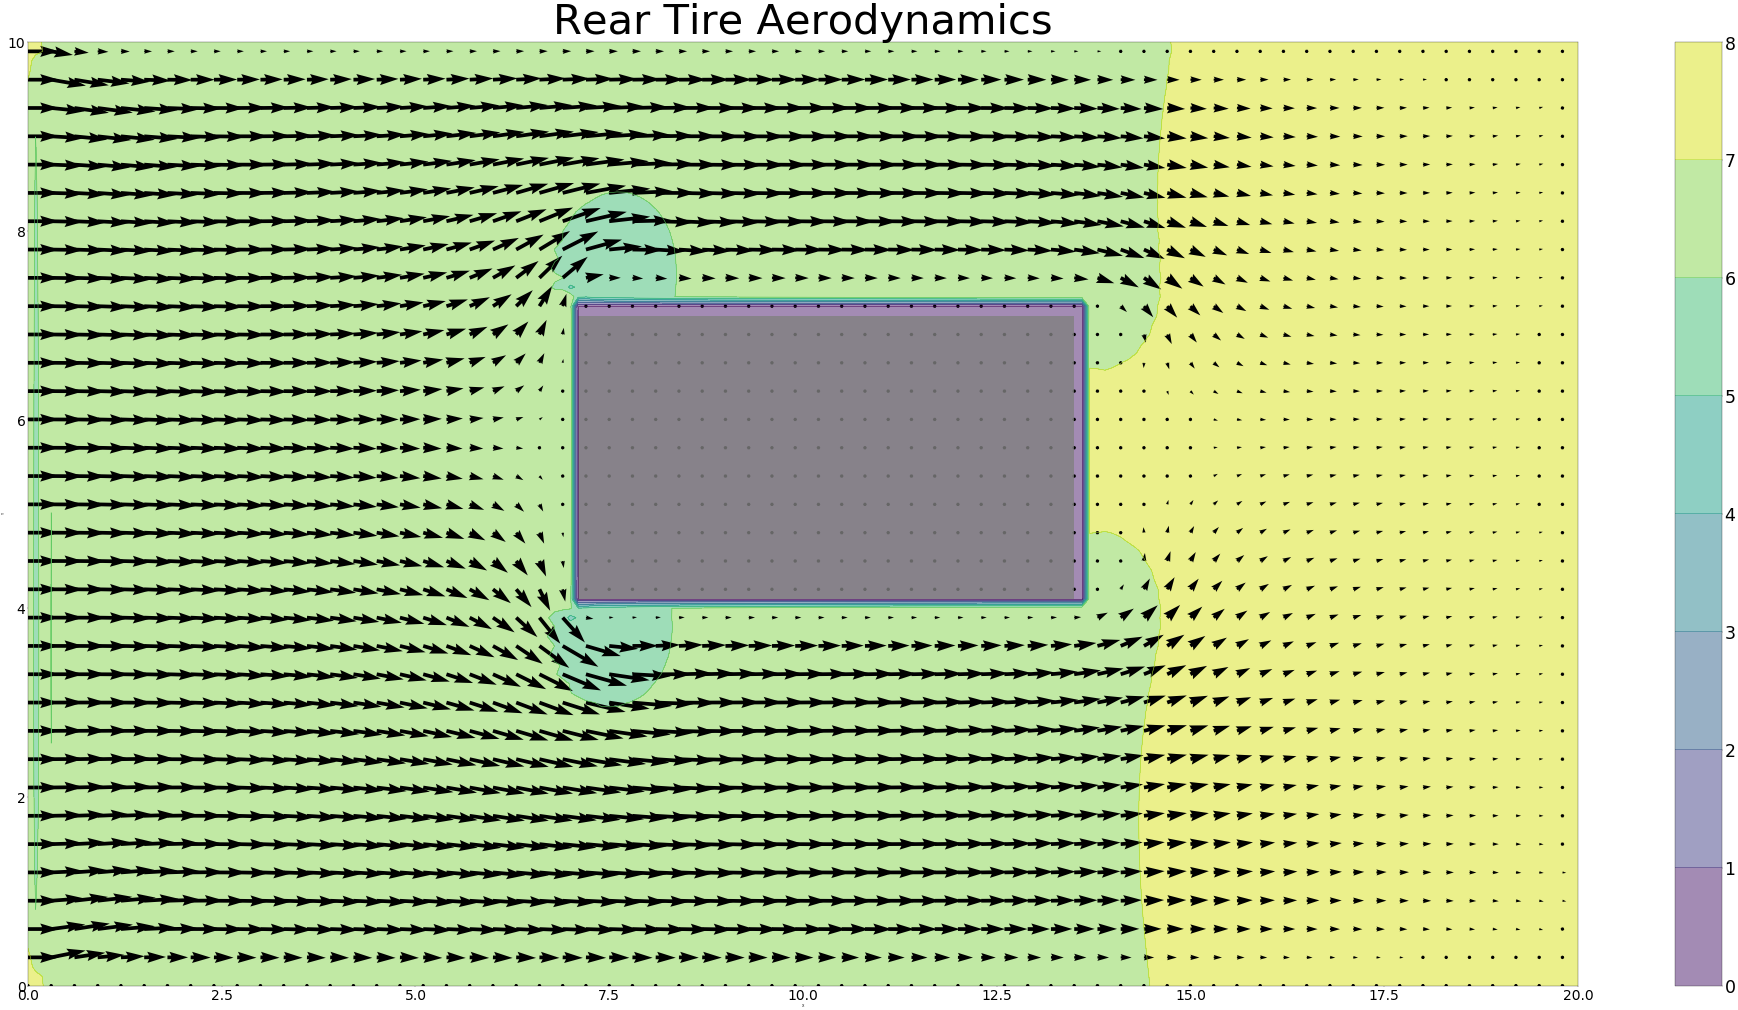

In [15]:
nx = 201  # x-points
ny = 101  # y-points
nit= 50
c =  1                       # phase propagation speed
x_span = 20.0
y_span = 10.0
dx = x_span/(nx-1)           # size of x-grid
dy = y_span/(ny-1)           # size of y-grid
x = np.linspace(0,x_span,nx) # last point included, so exactly nx points
y = np.linspace(0,y_span,ny) # last point included, so exactly ny points
X,Y = np.meshgrid(x,y)       # makes 2-dimensional mesh grid

botb  = 40           # bottom boundary of obstacle
dpth  = 33         # obstacle depth

lftb   = 70          # left boundary of obstacle
wdth   = 67          # obstacle width

Re = 50              # range from 10s to 100s 
nt = 1000            # timesteps

u_start = 1          # initial velocity at the start 
rho = 1              # density                
nu = ((dy*dpth)*u_start)/Re  # viscosity (UL/Re, Re = UL/nu, original value: 0.1)
dt = 0.001               # timesteps

qres = 3                 # quiver plot resolution

v = np.zeros((ny, nx))
u = np.ones((ny, nx))    # for u-velocity I initialise to 1 everywhere

p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

u, v, p = cavityFlow_16(nt, u, v, dt, dx, dy, p, rho, nu, botb, dpth, lftb, wdth, X, Y, u_start)

# Plot the last figure on screen
fig = plt.figure(figsize=(100,50), dpi=25)
plt.contourf(X, Y, p, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=50) 
plt.contour(X, Y, p)
plt.quiver(X[::qres,::qres],Y[::qres,::qres],u[::qres,::qres],v[::qres,::qres]) ##plotting velocity
plt.broken_barh([(x[lftb+1],x[lftb+wdth-2]-x[lftb+1])], (y[botb+1],y[botb+dpth-2]-y[botb+1]), facecolors='grey', alpha=0.8)
plt.xlabel('X')
plt.ylabel('Y');
plt.title('Rear Tire Aerodynamics', fontsize = 120)
plt.savefig('RT_aero.jpeg')